# Example implementation of attention from Bahdanau et. al
This notebook is an implementation from https://www.analyticsvidhya.com/blog/2019/11/comprehensive-guide-attention-mechanism-deep-learning/

In [1]:
import pandas as pd
from pandas import DataFrame as df
import numpy as np

In [2]:
# Load the amazon sentiment data as a pandas data frame 
raw_data = pd.read_csv('sentiment labelled sentences/amazon_cells_labelled.txt', delimiter='\t', header=None)

In [3]:
raw_data.shape

(1000, 2)

In [4]:
raw_data.head()

,0,1
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [5]:
corpus = np.asarray(raw_data[0])
labels = np.asarray(raw_data[1])

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [7]:
# Tokenize the text and generate sequences 
t=Tokenizer()
t.fit_on_texts(corpus)
text_matrix=t.texts_to_sequences(corpus)

In [8]:
vocab_len = len(t.get_config()['word_counts'])

In [9]:
vocab_len

24868

In [10]:
# Find the maximum length of sentences to set the 
len_mat=[len(text) for text in text_matrix]
features = max(len_mat)

In [11]:
features

30

In [12]:
# Pad sequences < max length of sentences with 0s
data = pad_sequences(text_matrix, maxlen=features, padding='post')

In [13]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, LSTM, Embedding, Layer
import tensorflow.keras.backend as K

In [14]:
# LSTM model without attention
inputs=Input(shape=(features,))
x=Embedding(input_dim=vocab_len+1,output_dim=features,\
             input_length=features,embeddings_regularizer=l2(.001))(inputs)
x=LSTM(100,dropout=0.3,recurrent_dropout=0.2)(x)
outputs=Dense(1,activation='sigmoid')(x)


In [15]:
model=Model(inputs,outputs)


In [16]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 30)            746070    
_________________________________________________________________
lstm (LSTM)                  (None, 100)               52400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 798,571
Trainable params: 798,571
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [18]:
lstm_layer = model.layers[2]
lstm_layer

In [19]:
for weights in lstm_layer.get_weights():
    print(len(weights))

30
100
400


In [20]:
epochs = 30

In [ ]:
model.fit(x=data,y=labels,batch_size=100,epochs=epochs,verbose=1,shuffle=True,validation_split=0.2)

In [64]:
# Attention Layer from Bahdanau et. al 
# https://arxiv.org/abs/1409.0473
import sys
import traceback
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)
        self.attention = []
        #self.call_count = tf.Variable(0)
        self.call_count = 0

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")  
        print(self.W.shape, ' ', self.b.shape)
        
        super(attention, self).build(input_shape)
        
    def call(self,x):
        #K.set_value(self.call_count, K.get_value(self.call_count)+1)
        self.call_count += 1
        tf.print(self.call_count)
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        #tf.print(et)
        at=K.softmax(et)
        tf.print(at)
        self.attention.append(at)
        at=K.expand_dims(at,axis=-1)
        #print(at)
        output=x*at
        #print(output)
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        config = super(attention,self).get_config()
        config['attention'] = self.attention
        config['call_count'] = self.call_count
        return config
    

In [65]:
# LSTM model with attention
inputs_att=Input((features,))
x=Embedding(input_dim=vocab_len+1,output_dim=features,input_length=features,\
            embeddings_regularizer=l2(.001))(inputs_att)
att_in=LSTM(100,return_sequences=True,dropout=0.3,recurrent_dropout=0.2)(x)
att_out=attention()(att_in)
outputs_att=Dense(1,activation='sigmoid',trainable=True)(att_out)

(100, 1)   (30, 1)


In [66]:
model_att=Model(inputs_att,outputs_att)
model_att.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 30)]              0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 30, 30)            746070    
_________________________________________________________________
lstm_9 (LSTM)                (None, 30, 100)           52400     
_________________________________________________________________
attention_8 (attention)      (None, 100)               130       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 798,701
Trainable params: 798,701
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_att.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])
model_att.fit(x=data,y=labels,batch_size=100,epochs=epochs,verbose=1,shuffle=True,validation_split=0.2)

In [72]:
example = data[0:1]
example

array([[ 33, 117,   5,  53, 214,  11,  47,   8, 155,   4,  19, 337,  19,
          1, 546, 416,   2, 241, 190,   6, 812,   0,   0,   0,   0,   0,
          0,   0,   0,   0]], dtype=int32)

In [38]:
a = model.history.history['val_acc']

In [23]:
b = model_att.history.history['val_acc']

In [24]:
from matplotlib import pyplot as plt

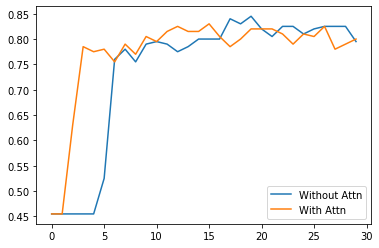

In [25]:
plt.plot(range(epochs), a,b)
plt.legend(['Without Attn', 'With Attn'])